In [1]:
## Plots whole trace with step segments (1-6) highlighted !!! Only pulling in a single csv file for 22 STI, pulling in more yields MemoryError
import pandas as pd
import glob
import os
import numpy as np
import dask.dataframe as dd
from datetime import datetime,timedelta
import time
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import interpolate
from tqdm import tqdm                       # For progress bar, yay!

In [2]:
process = 'SLIT INTEGRATED DRY ETCH' #'22 STI INTEGRATED DRY ETCH' # 'GH CONTACT OXIDE DRY ETCH' # 'SLIT INTEGRATED DRY ETCH'
if process == 'GH CONTACT OXIDE DRY ETCH':
    metro_cols = ['waferscribe','ext_mv']
    txt = "metro/GHContactOx"
    oes_cols = ['WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID','OESIB1','OESIB2','OESIB3','OESIB4','OESIB5','OESIB6','OESIB7','OESIB8'] # GHContact
    csv = "oes/3500-GH CONTACT OXIDE DRY ETCH_"
elif process == '22 STI INTEGRATED DRY ETCH':
    metro_cols = ['waferscribe','ext_mv']
    txt = "metro/22STIINT"
    oes_cols = ['WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID','OES_BCl272','OES_C516','OES_CN387','OES_CO483','OES_F703','OES_H656','OES_O777','OES_OH309','OES_Si251','OES_Si288'] # 22STI
    csv = "oes/5030-22 STI INTEGRATED DRY ETCH_"
elif process == 'SLIT INTEGRATED DRY ETCH':
    metro_cols = ['WaferScribe','DEPTH_SLIT_BOX11'] # DEPTH_SLIT_BOX11    HEIGHT_OXIDE_TOP_BOX11    OCD_SLIT_TOP_BOX11
    txt = "metro/46slit"
    oes_cols = ['WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID','OESIB1','OESIB2','OESIB3','OESIB4','OESIB5','OESIB6','OESIB7','OESIB8'] # GHContact
    csv = "oes/46SLITintegrated"

In [3]:
# Retrieving Metro Data from .txt files
mfile = []
metro = {}
#metro_cols = ['waferscribe','ext_mv'] # DEPTH_SLIT_BOX11    HEIGHT_OXIDE_TOP_BOX11    OCD_SLIT_TOP_BOX11    ext_mv
print('Reading Metro Data')
for filename in glob.glob(txt+"*"): # Reading txt files
    metro[filename[6:-4]] = pd.read_csv(filename,
                                        usecols=metro_cols)[metro_cols] # Using filenames w/out path and file type as dictionary keys
    mfile.append(filename[6:-4])  # Create index of filename strings
    print(f'\t{filename} Data Finished')
    met = pd.concat(metro.values(),ignore_index=True)

# Trim down 'met' to relevant ext_mv values
paramVal = met[metro_cols[1]]     # type(paramVal)    = pandas.core.series.Series
paramBool = met[paramVal%1==0]
dropParam = paramBool.index
met.drop(dropParam, inplace=True)
MetroWafers = met[metro_cols[0]]    # type(MetroWafers) = pandas.core.series.Series

Reading Metro Data
	metro\46slit.csv Data Finished


In [4]:
# Retrieving OES Data from the .csv files, takes MUCH longer, retrieving specfic columns helps
ofile = []
oes = {}
data = {}
#oes_cols = ['WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID', 'OES_CO483', 'OES_C516', 'OES_CN387'] # For STI INTEGRATED 
#oes_cols = ['LOT_ID','WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID', 'OES_BCl272', 'OES_C516', 'OES_CN387', 'OES_CO483', 'OES_F703', 'OES_H656', 'OES_O777', 'OES_OH309','OES_Si251','OES_Si288'] # For STI INTEGRATED
#oes_cols = ['WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID', 'OESIB1', 'OESIB2', 'OESIB3', 'OESIB4', 'OESIB5', 'OESIB6', 'OESIB7', 'OESIB8'] # For GH CONTACT 
print('Reading OES Data')
    # 5030-22 STI INTEGRATED DRY ETCH_2 
    # 3500-GH CONTACT OXIDE DRY ETCH_1
    # 5030-46 SLIT INTEGRATED DRY ETCH_1
for filename in glob.glob(csv+"*.csv"): 
    oes[filename[4:-4]] = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(filename, 
                             header=0, 
                             usecols=oes_cols, 
                             parse_dates=['RunStartTime', 'TimeStamp'], 
                             infer_datetime_format=True, 
                             chunksize=1000)):
        oes[filename[4:-4]] = pd.concat([oes[filename[4:-4]], chunk], ignore_index=True)
        #print(oes[filename[4:-4]])
    print(f'\t{filename} Data Finished')
data = pd.concat(oes.values(),ignore_index=True)

6it [00:00, 51.25it/s]

Reading OES Data


1049it [00:53, 19.55it/s]
7it [00:00, 59.97it/s]

	oes\46SLITintegrated1.csv Data Finished


1049it [00:52, 20.00it/s]
7it [00:00, 63.31it/s]

	oes\46SLITintegrated2.csv Data Finished


1049it [00:51, 20.19it/s]
7it [00:00, 68.44it/s]

	oes\46SLITintegrated3.csv Data Finished


1049it [00:51, 20.25it/s]


	oes\46SLITintegrated4.csv Data Finished


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4194300 entries, 0 to 4194299
Data columns (total 12 columns):
RunStartTime    datetime64[ns]
TimeStamp       datetime64[ns]
WAFER_SCRIBE    object
OESIB1          float64
OESIB2          float64
OESIB3          float64
OESIB4          float64
OESIB5          float64
OESIB6          float64
OESIB7          float64
OESIB8          float64
StepID          float64
dtypes: datetime64[ns](2), float64(9), object(1)
memory usage: 368.0+ MB


In [23]:
# Trim down 'data' to only metro-matching wafers by removing them
UniqueWafers = data.WAFER_SCRIBE.unique()
nonWafers = np.isin(UniqueWafers,list(MetroWafers),invert=True)
i = np.where(nonWafers)[0]
WaferScribe = []
WaferScribe = (UniqueWafers[i])
print('Trimming Down Data to Only Metro-Matching Wafers')
indexNames = []
for x in tqdm(WaferScribe):
    WaferScribeData = data['WAFER_SCRIBE']
    dataindex = data[WaferScribeData == x]
    indexNames = dataindex.index
    data.drop(indexNames , inplace=True)
print('\tDone!') 
UniqueWafers = data.WAFER_SCRIBE.unique()

  0%|                                                                                          | 0/725 [00:00<?, ?it/s]

Trimming Down Data to Only Metro-Matching Wafers
6011
4194300


  0%|                                                                                          | 0/725 [00:00<?, ?it/s]


MemoryError: Unable to allocate array with shape (9, 4188289) and data type float64

In [16]:
# Turning Data into Wafer for easy keys and converting dates into 
t_sec = {}
Wafer = {}
DataFrameDict = {elem : pd.DataFrame for elem in UniqueWafers}
print('Creating Wafer Data Set & Processing Dates into Time in Seconds')
for i,key in enumerate(tqdm(DataFrameDict.keys())):
    Wafer[i] = pd.DataFrame.from_dict(data[:][data.WAFER_SCRIBE == key]) # Create DataFrame for specific wafers
    delt = Wafer[i]['TimeStamp']-Wafer[i]['RunStartTime'] # Find timedelta for a wafer
    t_sec[i] = delt.dt.total_seconds() # Put timedelta into seconds
print('\tDone!')
OES_col = [col for col in Wafer[i].columns if 'OES' in col] #Create list of all intensity columns w/rt element
step = 6

wafer_param_time = met[metro_cols]
etch_time = []
#step = 1
# Only temporarily kept in here

0it [00:00, ?it/s]

Creating Wafer Data Set & Processing Dates into Time in Seconds
	Done!


TypeError: unhashable type: 'numpy.ndarray'

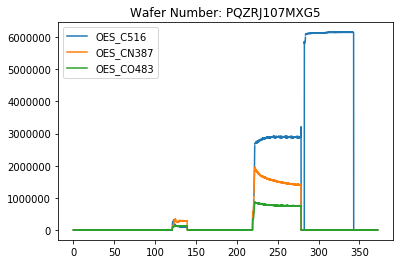

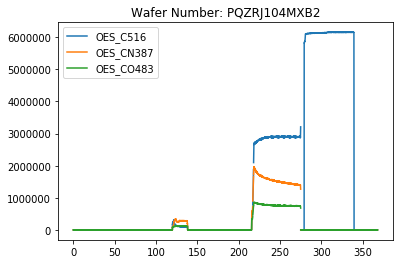

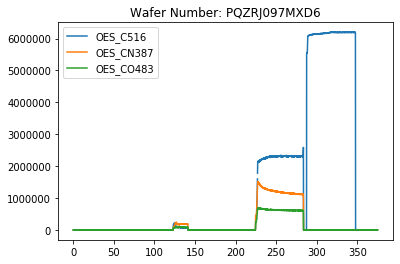

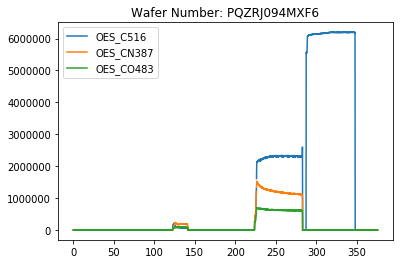

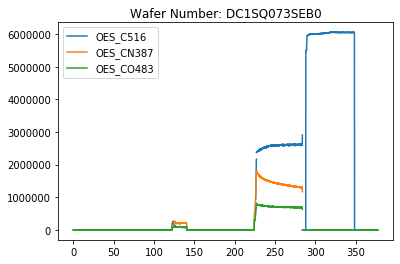

In [8]:
for x in range(5): # len(UniqueWafers)): # 1): # 
    fig = plt.figure()
#    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==1]
#    plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:red") #, ymin=0, ymax=1, **kwargs)
#    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==2]
#    plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:orange") #, ymin=0, ymax=1, **kwargs)
#    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==3]
#    plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:pink") #, ymin=0, ymax=1, **kwargs)
#    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==4]
#    plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:purple") #, ymin=0, ymax=1, **kwargs)
#    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==5]
#    plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:blue") #, ymin=0, ymax=1, **kwargs)
#    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==6]
#    plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:cyan") #, ymin=0, ymax=1, **kwargs)
#    try:
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==7]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:green") #, ymin=0, ymax=1, **kwargs)
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==8]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:olive") #, ymin=0, ymax=1, **kwargs)
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==9]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:grey") #, ymin=0, ymax=1, **kwargs)
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==10]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:brown") #, ymin=0, ymax=1, **kwargs)
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==11]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:red") #, ymin=0, ymax=1, **kwargs)
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==12]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:orange") #, ymin=0, ymax=1, **kwargs)
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==13]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:pink") #, ymin=0, ymax=1, **kwargs)
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==14]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:purple") #, ymin=0, ymax=1, **kwargs)
#        Tsteps = t_sec[x].loc[Wafer[x]['StepID']==15]
#        plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25, color = "tab:blue") #, ymin=0, ymax=1, **kwargs)
#    except:
#        pass
    #x_int = np.linspace(Tsteps.iloc[0], Tsteps.iloc[-1], 100)
    plt.title(f"Wafer Number: {UniqueWafers[x]}")
    for y in range(len(OES_col)):
        #Intensity = Wafer[x][OES_col[y]].loc[Wafer[x]['StepID']==step]
        #plt.plot(Tsteps,Intensity, label=f"{OES_col[y]}") #,color="tab:orange")
        plt.plot(t_sec[x],Wafer[x][OES_col[y]],label = f"{OES_col[y]}")
        #plt.ylim(-3e5,4e5)
        plt.legend()
plt.show()
